# **Twitter Sentiment Classification**

By : [Ferrey Adinarta](https://id.linkedin.com/in/ferrey-adinarta-b53911230)


Dataset : [Tweets Dataset]()

Menganalisis tweets dari twitter/X dengan 800.000+ tweets dari tahun 2022

# Mengimpor Data dari Kaggle ke Colab

In [177]:
from google.colab import files
! pip install -q kaggle

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [178]:
! kaggle datasets download -d tariqsays/sentiment-dataset-with-1-million-tweets
! unzip sentiment-dataset-with-1-million-tweets.zip

sentiment-dataset-with-1-million-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment-dataset-with-1-million-tweets.zip
replace dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Mengimpor Library

In [83]:
# Library untuk Analisis dan Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

# Library untuk Pre-Processing text
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Library untuk Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Memasukkan Data ke Colab

In [84]:
data=pd.read_csv('/content/dataset.csv')
print(data.shape)
data.info()

(937854, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


Penjelasan Kolom:
1. Text : Isi Tweet
2. Language : bahasa yang dipakai
3. Label : Tipe Sentimen

In [85]:
print(data['Language'].unique(),'\n')
print(data['Label'].unique())

['en' 'es' 'ca' 'fr' 'pt' 'ja' 'hi' 'ar' 'ko' 'nl' 'et' 'in' 'und' 'tl'
 'zh' 'de' 'cs' 'ru' 'qme' 'it' 'el' 'ro' 'no' 'tr' 'sv' 'ta' 'fa' 'ht'
 'pl' 'da' 'th' 'hu' 'lv' 'uk' 'qht' 'eu' 'qam' 'si' 'cy' 'zxx' 'ml' 'ne'
 'mr' 'qst' 'vi' 'bn' 'gu' 'is' 'fi' 'ckb' nan 'te' 'art' 'bg' 'ur' 'sl'
 'lt' 'pa' 'iw' 'kn' 'sr'
 "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]"
 "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]"
 'am' 'or'
 "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]"
 'sd'
 "[Photo(previewUrl='https://pbs.twimg.com/media/FWXXH-AUcAAp6Wc?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWXXH-AUcAAp6Wc?format=jpg&name=larg

<Figure size 1200x800 with 0 Axes>

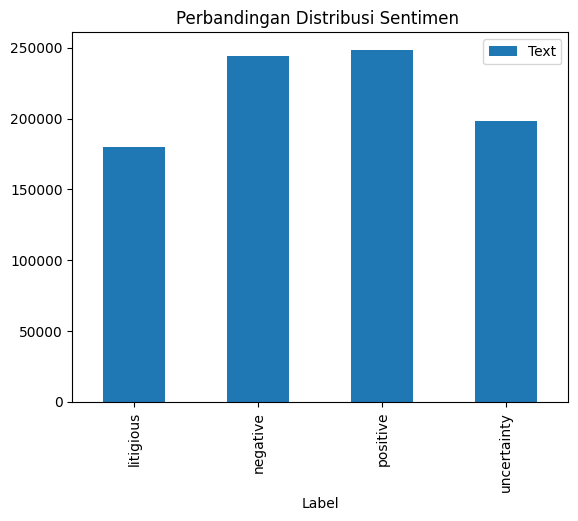

In [86]:
# mengurangi jumlah data yang dipakai dan kolom yang dipakai
data=data[data['Language']=='en']
data=data[['Text','Label']]
plt.figure(figsize=(12,8))
ax = data.groupby('Label').count().plot(kind='bar', title='Perbandingan Distribusi Sentimen ')

# Data Pre-Processing

Cek null

In [87]:
data.isnull().sum()

Text     0
Label    0
dtype: int64

Cek kolom duplikat

In [88]:
any(data.duplicated())

True

In [89]:
data=data.drop_duplicates()
data

,Text,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative
...,...,...
937849,@Juice_Lemons in the dark. it’s so good,positive
937850,8.SSR &amp; Disha Salian case should be solved...,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,negative
937852,@reblavoie So happy for her! She’s been incred...,positive


## Text Pre-processing

In [90]:
#emoji dictionary diambil dari website https://sheet.shiar.nl/emoji
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

#pattern text
url        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
user       = '@[^\s]+'
nonalpha      = "[^a-zA-Z0-9]"

In [91]:
data['processed_text'] = data['Text'].str.lower()
data['processed_text']=data.apply(lambda row : re.sub(url,"(URL)",row['processed_text']), axis=1)
for emoji in emojis.keys():
  data['processed_text']=data.apply(lambda row : row['processed_text'].replace(url,"(EMO)"+emojis[emoji]), axis=1)
data['processed_text']=data.apply(lambda row : re.sub(user,"(USER)",row['processed_text']), axis=1)
data['processed_text']=data.apply(lambda row : re.sub(nonalpha," ",row['processed_text']), axis=1)

In [92]:
stop_words= set(stopwords.words("english"))
word_lemmatizer=WordNetLemmatizer()
tokenized_texts = data['processed_text'].apply(word_tokenize)
processed_text=[]

for tokens in tokenized_texts:
    filtered_words = [word for word in tokens if word.lower() not in stop_words]
    lemmatized_words = [word_lemmatizer.lemmatize(word) for word in filtered_words]
    processed_text.append(' '.join(lemmatized_words))

data['processed_text'] = processed_text


In [93]:
data

,Text,Label,processed_text
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,litigious,USER USER USER USER testimony evidence court l...
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious,URL flagstar bank discloses data breach impact...
3,Rwanda is set to host the headquarters of Unit...,positive,rwanda set host headquarters united nation dev...
4,OOPS. I typed her name incorrectly (today’s br...,litigious,oops typed name incorrectly today brave witnes...
5,It sucks for me since I'm focused on the natur...,negative,suck since focused nature aspect thing environ...
...,...,...,...
937849,@Juice_Lemons in the dark. it’s so good,positive,USER dark good
937850,8.SSR &amp; Disha Salian case should be solved...,negative,8 ssr amp disha salian case solved amp drug ca...
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,negative,accident damage raleigh fire department 2503 f...
937852,@reblavoie So happy for her! She’s been incred...,positive,USER happy incredible


# Text visualization

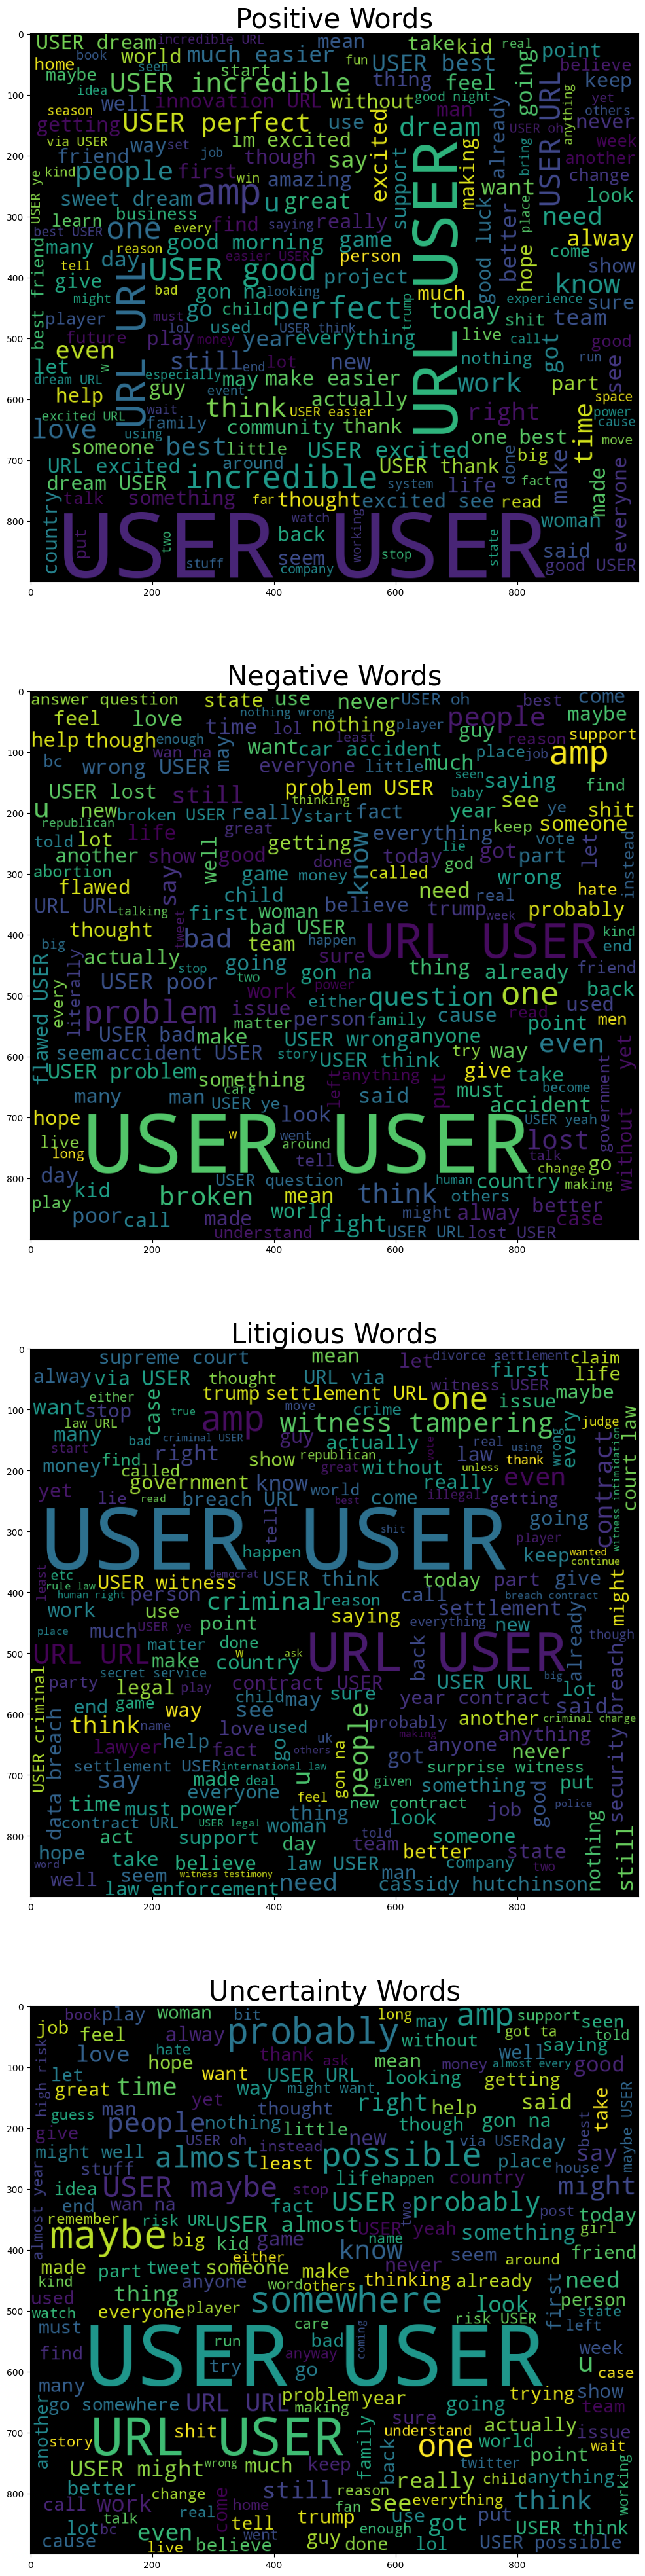

In [94]:
fig,axes=plt.subplots(nrows=4,ncols=1,figsize=(50,50))

word_positive = WordCloud(width=1000, height=900).generate(" ".join(data[data['Label'] == 'positive']['processed_text']))
word_negative = WordCloud(width=1000, height=900).generate(" ".join(data[data['Label']=='negative']['processed_text']))
word_litigious = WordCloud(width=1000, height=900).generate(" ".join(data[data['Label']=='litigious']['processed_text']))
word_uncertainty = WordCloud(width=1000, height=900).generate(" ".join(data[data['Label']=='uncertainty']['processed_text']))

axes[0].set_title('Positive Words', fontsize=30)
axes[0].imshow(word_positive)

axes[1].set_title('Negative Words', fontsize=30)
axes[1].imshow(word_negative)

axes[2].set_title('Litigious Words', fontsize=30)
axes[2].imshow(word_litigious)

axes[3].set_title('Uncertainty Words', fontsize=30)
axes[3].imshow(word_uncertainty)

# TF-IDF dan Logistic Regression

In [128]:
# pembagian data untuk train dan test
sentiment=list(data['Label'])
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], sentiment, test_size=0.1)

In [143]:
use_model=Pipeline([
    ('vector',TfidfVectorizer()),
    ('MNB',MultinomialNB())
    ])
use_model.fit(X_train,y_train)

Pipeline(steps=[('vector', TfidfVectorizer()), ('MNB', MultinomialNB())])

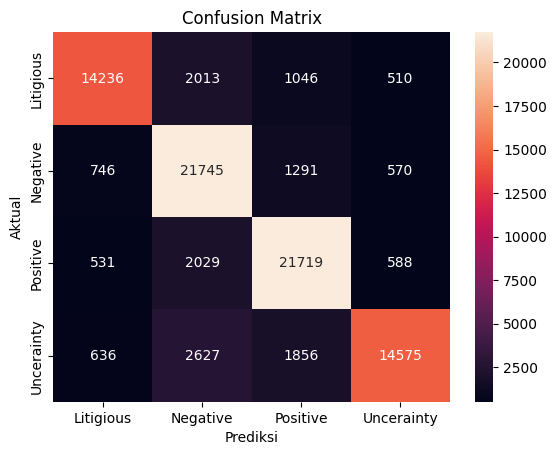

In [140]:
y_pred = use_model.predict(X_test)
confuse_matrix=confusion_matrix(y_test,y_pred)

sns.heatmap(confuse_matrix, annot=True, fmt='d',
            xticklabels=['Litigious','Negative','Positive','Uncerainty'], yticklabels=['Litigious','Negative','Positive','Uncerainty'])

plt.title("Confusion Matrix")
plt.ylabel("Aktual")
plt.xlabel("Prediksi")
plt.show()

In [141]:
# hasil report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   litigious       0.88      0.80      0.84     17805
    negative       0.77      0.89      0.82     24352
    positive       0.84      0.87      0.86     24867
 uncertainty       0.90      0.74      0.81     19694

    accuracy                           0.83     86718
   macro avg       0.85      0.83      0.83     86718
weighted avg       0.84      0.83      0.83     86718



In [149]:
print(use_model.predict(['Best algorithm ever']))
print(use_model.predict(['I will be your judge']))
print(use_model.predict(['You are dumb']))
print(use_model.predict(['Where to go?']))

['positive']
['litigious']
['negative']
['uncertainty']
